In [1]:
import pickle 
import numpy as np 
import pandas as pd
import networkx as nx
from tqdm import tqdm
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import community
import collections
import scipy.stats

from src.utils.data_utils import *
from src.utils.general_utils import *
from src.utils.Director_Actor import *

# P3 : Directors and actors

This notebook will present all the main results of the analysis of the final axis of the project. This axis is directed towards the relationship between actors and directors.

The directors of each movie were previously found with the IMDb dataset. Only a little information about each director was found, such as date of birth/death, name, as well as the list of movies they directed. Nevertheless, we will extract additional information about each directors with the films.

The goal of this part would be to link actors who were successful during their career to directors using a bipartite directed graph. The directed graph would be from the actor to the director. The weight of each edge would be the number of movies where the actor and the director were together. The value at the node of the director would be the sum of the weight of each edge coming to him. By doing so, we hope to analyse the link between successful actors and directors and see if directors who have higher value have better careers and what are the factors that help them achieve these high counts. In order to quantify the successfulness of an actor, multiple criteria were applied to each actors : such as number of films, average ratings, average ratings per genre, centrality and degree of node. They will be better explained throughout this section. 

The major research question of this line of analysis would be:\
**What are the links between successful actors and directors ?**

Here is the global strategy that we will use to answer these questions:
1. Pre-process some data (specific way for this section as there is now directors)
2. Compute metrics about actors and their network
3. Analyse the metrics to determine who and what is a successful actor
4. Create a directed bipartite network between successful actors and directors
5. Determined the most highly valued directors
6. Analyse and compares the directors between them
7. **Conclusion** : Find the relationship between a high-valued director and a successful actor 

## 0. Loading Value

In [2]:
movie_path = 'data/Movie.pkl'
actors_path = 'data/Actor.pkl'

with open(movie_path, 'rb') as file:
    Movie = pickle.load(file)

with open(actors_path, 'rb') as file:
    Actor = pickle.load(file)

In [3]:
print(f'Shape of Actor :{Actor.shape}')
print(f'Shape of Movie :{Movie.shape}')

Shape of Actor :(135760, 8)
Shape of Movie :(61042, 26)


In [4]:
Movie.head()

,IMDb_title_ID,release_date,runtime,Primary_title,Original_title,Average rating,number of votes,IMDb_director_ID,IMDb_writers_ID,Producer name,...,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,modified_title_y
1894missjerry,tt0000009,1894,45,Miss Jerry,Miss Jerry,5.4,216.0,nm0085156,nm0085156,Alexander Black,...,10109752,/m/02q23xk,Miss Jerry,1894,<NA>,<NA>,Silent film,United States of America,"Short Film, Silent film, Indie, Black-and-white",missjerry
1897thecorbettfitzsimmonsfight,tt0000147,1897,100,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,5.2,540.0,nm0714557,<NA>,Enoch J. Rector,...,28703057,/m/0czdh_n,The Corbett-Fitzsimmons Fight,1897,100000.0,<NA>,,,Sports,thecorbettfitzsimmonsfight
1906thestoryofthekellygang,tt0000574,1906,70,The Story of the Kelly Gang,The Story of the Kelly Gang,6.0,938.0,nm0846879,nm0846879,Charles Tait,...,142995,/m/0120y4,The Story of the Kelly Gang,1906,<NA>,70.0,English Language,Australia,"Crime Fiction, Silent film, Biography, Indie, ...",thestoryofthekellygang
1908hamlet,tt0000630,1908,<NA>,Hamlet,Amleto,3.1,30.0,nm0143333,nm0000636,Mario Caserini,...,15128675,/m/03hjcy9,Hamlet,1908,<NA>,<NA>,French Language,France,"Silent film, Drama",hamlet
1908thefairylogueandradioplays,tt0000679,1908,120,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,5.2,77.0,"nm0091767,nm0877783","nm0000875,nm0877783","Francis Boggs, Otis Turner",...,5954041,/m/0fgfyy,The Fairylogue and Radio-Plays,1908,<NA>,120.0,English Language,United States of America,"Silent film, Black-and-white",thefairylogueandradioplays


In [5]:
Actor.head()

,Freebase_actor_ID,actor_name,actor_DOB,actor_gender,actor_height,ethnicity,Freebase_movie_ID,actor_age_atmovierelease
0,/m/010p3,Adam Carolla,1964-05-27,M,1.88,Italian Americans,"[/m/0bq2wj, /m/08hjr9, /m/06zm9p7, /m/06c5z_, ...","[35.0, 35.0, 45.0, 33.0, 33.0, 34.0, 42.0, 35...."
1,/m/010q36,Fred Rogers,1928-03-20,M,NaN,None,[/m/033pf1],[67.0]
2,/m/010wx,Aria Giovanni,1977-11-03,F,1.68,Yugoslavs,[/m/07gx0c],[25.0]
3,/m/010xjr,Richard Harris,1930-10-01,M,1.85,Irish people,"[/m/0c_6bf, /m/078mm1, /m/03qfyt, /m/0cz7_4w, ...","[66.0, 46.0, <NA>, 59.0, 48.0, 39.0, 66.0, 50...."
4,/m/0112yl,Toshiro Mifune,1920-04-01,M,1.74,None,"[/m/0513nd, /m/05c2g3q, /m/04wjg1, /m/01tch8, ...","[31.0, 42.0, 45.0, 41.0, 62.0, 29.0, 30.0, 38...."


In [6]:
Director = create_Director_profile(Movie)
Director.head()

,IMDb_director_ID,director_name,birthYear_director,deathYear_director,Freebase_movie_ID,age_at_movie_release
0,nm0000005,Ingmar Bergman,1918.0,2007,"[/m/02r9cv1, /m/05nrqp, /m/05ppr_, /m/027yppr,...","[28.0, 28.0, 29.0, 30.0, 30.0, 31.0, 31.0, 32...."
1,nm0000008,Marlon Brando,1924.0,2004,[/m/02616b],[37.0]
2,nm0000009,Richard Burton,1925.0,1984,[/m/095s_p],[42.0]
3,nm0000018,Kirk Douglas,1916.0,2020,"[/m/04f5xbz, /m/0h3ph1j]","[59.0, 57.0]"
4,nm0000019,Federico Fellini,1920.0,1993,"[/m/09rwr0, /m/0b0gjq, /m/09sgmx, /m/074x3d, /...","[30.0, 33.0, 33.0, 34.0, 40.0, 42.0, 43.0, 45...."


## 1. Pre-processing of the data

In this section, we will apply the previously defined function in order to gain more information about our dataframe. Information such as the starting age of the career or the number of films played per genre will be computed using others informations in the respective dataframe of the actors and directors.

An important additional note is that throughout the notebook, the metrics related to actors will only be calculated for actors which played in at least 5 movies. This also applies for later when the bipartite network between actors and film for actors will be computed. This is justified and motivated by the following reasons :</br>
Firstly, it is that being in at least 5 movies can be considered as a characterics that is common to successfull actors. Indeed, a "true" actor will not only participate in 2 or 3 movies if he plan on having a career. His goal would be to participate in multiple movies.</br>
Secondly, an actor which only participate in one movie is pretty common. Adding an actor which only played in one movie is not relevant as this person may have been a figurant in a movie and hence is not really part of the film industry. This is not relevant with the aspect of our study.</br>
Finally, it also reduce the necessary computing time of the code. Computing the network of all actors through their relation based on their movie can be rather long and if not information can be obtained for actors who only participate in one movie then it is not worth to add them to the network.

Later on, as we determine what are the characteristics of a successful actor, this threshold may by updated and increased. This same process will not be applied to the directors because the purpose is to determine the successfull directors in function of the actors. Hence, the list of directors will be found from the remaining actors. Nevertheless, new characterics will also be added to the directors and some directors may be dropped due to lack of information about them. 

In [7]:
# Applying different function to the actor in order to obtain new information 

# Computing the starting age of their career
Actor = Actor_age_start(Actor)
# Computing the number of films in which the actor played
Actor = Actor_NOF(Actor)
# Finding the ratings of all of their movies
Actor = Actor_ratings(Actor,Movie)
# Computing their mean rating based on their movies
Actor = Actor_mean_rating(Actor)

In [8]:
# Verifying the number of missing values
print(f"The total number of actors is : {Actor.shape[0]}")
print(f"The total number of missing values in each column is :")
Actor.isna().sum()

The total number of actors is : 135760
The total number of missing values in each column is :


Freebase_actor_ID                0
actor_name                     338
actor_DOB                    77187
actor_gender                 38377
actor_height                122904
ethnicity                   127865
Freebase_movie_ID                0
actor_age_atmovierelease         0
Career_Start_age             83923
Number_of_films                  0
Ratings                          0
Mean_Rating                  40422
dtype: int64

In [9]:
# Filter actors who have played in at least 5 films
Actor_5 = Actor[Actor['Number_of_films'] >= 5]

# Verifying the number of missing values
print(f"The total number of actors which played in 5 films is : {Actor_5.shape[0]}")
print(f"This represents {Actor_5.shape[0]/Actor.shape[0]:.2%} of the total numbers of actors")
print(f"The total number of missing values in each column is for this new dataframe is :")
Actor_5.isna().sum()

The total number of actors which played in 5 films is : 19472
This represents 14.34% of the total numbers of actors
The total number of missing values in each column is for this new dataframe is :


Freebase_actor_ID               0
actor_name                      6
actor_DOB                    1607
actor_gender                  217
actor_height                12318
ethnicity                   15149
Freebase_movie_ID               0
actor_age_atmovierelease        0
Career_Start_age             3332
Number_of_films                 0
Ratings                         0
Mean_Rating                 13542
dtype: int64

A lot of actors were dropped from the dataframe, as expected. As a comparaison, even by keeping only the actors which have played in at least two movies, the total proportion that is kept from the original dataframe is only 36%. As can be seen, by dropping actors which did not played in a lot of movies, a lot less values are missing from each of the columns meaning that the actors which played in more movies have more information about them available. This is good as doing analysis on empty columns would be less interesting and harder.

In [10]:
# Applying different function to the director in order to obtain new information 

# Computing the starting age of their career
Director = Director_age_start(Director)
# Computing the number of films in which the actor played
Director = Director_NOF(Director)
# Finding the ratings of all of their movies
Director = Director_ratings(Director,Movie)
# Computing their mean rating based on their movies
Director = Director_mean_rating(Director)

In [11]:
# Verifying the number of missing values
print(f"The total number of directors is : {Director.shape[0]}")
print(f"The total number of missing values in each column is :")
Director.isna().sum()

The total number of directors is : 23518
The total number of missing values in each column is :


IMDb_director_ID            0
director_name               0
birthYear_director       9884
deathYear_director          0
Freebase_movie_ID           0
age_at_movie_release        0
Career_Start_age        10340
Number_of_films             0
Ratings                     0
Mean_Rating              2245
dtype: int64

As can be seen there are less values missing in the director dataframe. This was expected as every directors is "important", on the oppostite, actors can be figurant and hence less informations are known about them.

We will now compute the number of movies per genre and also their ratings as well as the number of movies per genre per actor and their ratings depending on the genre. This will also be done for the directors. This is motivated by the fact that depending on the genre, the average ratings may be below or above the total average (for example, comedic films tends to have lower ratings, nevertheless famous comedic actors can still be considered successfull despite a low ratings). Based on this fact, if we want to use the metrics of the ratings to determine the relative success of an actors with respect to its genre, we also need its ratings per genre. This will also help determine what specific genre of movies is an actor related to. Some actors only do action or drama or comedic movies. The same reflexion can be made for the directors

In [12]:
# Computing the metrics related to the number of movie per genre and number of film per genre per actor
start_time = time.time()
Actor_Top_genre = Actor_genre_count_ratings(Actor_5, Movie,min_movies=5)
Director_Top_genre = Director_genre_count_ratings(Director, Movie,min_movies=1)
Genre_counts = Number_per_genre(Movie, Min_movie=0)

# Printing the results
print(f"The total number of genres is : {Genre_counts.shape[0]}")
print(f"The total number of movies is : {Movie.shape[0]}")

end_time = time.time()
print(f"Computation time:{time.time()-start_time:.2f}")

The total number of genres is : 361
The total number of movies is : 61042
Computation time:47.55


In [13]:
Genre_counts.head()

,Movie_genres,Count,Average rating
0,Drama,28914,6.397012
1,Comedy,12561,6.085487
2,Romance Film,9255,6.235040
3,Action,7468,5.849952
4,Thriller,7333,5.950014


In [14]:
Actor_Top_genre.head()

,Top_1_Genre,Top_1_Number,Top_1_Rating
Freebase_actor_ID,,,
/m/010p3,Romance Film,8,5.000000
/m/010xjr,Adventure,33,6.568421
/m/0112yl,Japanese Movies,36,7.476471
/m/011_3s,Drama,26,6.444444
/m/011_c4,Crime Fiction,7,6.666667


We will now dropped the actors and directors which we do not know their top genre.

In [15]:
# Merging the results and dropping the row where there is no top genre 
print(f"There was {Actor_5.shape[0]} actors.")
Actor_5 = Actor_5.merge(Actor_Top_genre, how='inner', left_on='Freebase_actor_ID', right_index=True)
print(f"There is now {Actor_5.shape[0]} actors.")

There was 19472 actors.
There is now 19322 actors.


In [16]:
# Merging the results and dropping the row where there is no top genre 
print(f"There was {Director.shape[0]} directors.")
Director = Director.merge(Director_Top_genre, how='inner', left_on='IMDb_director_ID',right_index=True)
print(f"There is now {Director.shape[0]} directors.")

There was 23518 directors.
There is now 23518 directors.


As can be seen from the computation of the ratings per genre, there is 361 different genres of movies. This is quite large and some genre are quite specific (for example there is LGBTQ, Gay and Gay interest but all Gay and Gay interest are also labelled as LGBTQ). In addition to that, some movies possessed multiple genres, certain 5 others only 1. Due to these reasons, it was decided to only considers the genre where there was at least a specific number of movies.</br>
By doing so, only the most relevant and "common/basic" genres will be kept. This will facilitate the analysis in order to determine the successfullness of an actor and the "type of actor" they are. In order to determine the right threshold, the elbow method was applied.

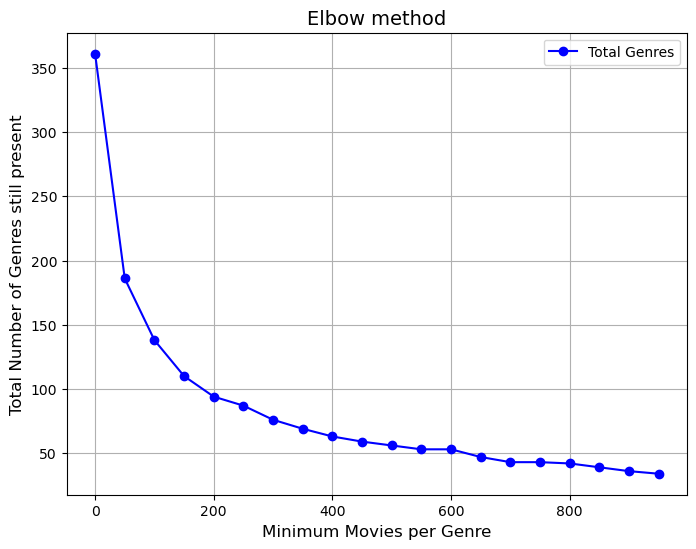

In [17]:
# Elbow method to determine the best threshold for the number of movies per genre
total_genres_per_number  = []
Number_of_movies = []

# Compute the number of genres of movies for a specific number and add the result to a list
for i in range(20):
    a = i*50
    genre_counts = Number_per_genre(Movie, Min_movie=a)
    total_genres_per_number.append(len(genre_counts))
    Number_of_movies.append(a)

# Plot of the elbow method
plt.figure(figsize=(8, 6))
plt.plot(Number_of_movies, total_genres_per_number, marker='o', linestyle='-', color='b', label='Total Genres')
plt.title('Elbow method', fontsize=14)
plt.xlabel('Minimum Movies per Genre', fontsize=12)
plt.ylabel('Total Number of Genres still present', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

As can be seen from the plot above, the elbow happens between 150 and 200 movies. Consequently, it was decided to only keep the genre with more than 200 movies

In [18]:
# Computing the final number of genres for 200 films
Genre_counts_200 = Number_per_genre(Movie, Min_movie=200)
print(f"There is {Genre_counts_200.shape[0]} genres with at least 200 movies")
Genre_counts_200.head(10)

There is 94 genres with at least 200 movies


,Movie_genres,Count,Average rating
0,Drama,28914,6.397012
1,Comedy,12561,6.085487
2,Romance Film,9255,6.235040
3,Action,7468,5.849952
4,Thriller,7333,5.950014
5,World cinema,6759,6.470132
6,Black-and-white,6501,6.455730
7,Crime Fiction,6154,6.196113
8,Indie,4753,6.106063
9,Adventure,4096,5.979210


We must now verify that each actor in `Actor_5` has their primary genre also in our list of genres from the elbow method. 

In [19]:
# verify that each top genres is also in our genre with more than 200 movies
df_actors = pd.DataFrame(np.where(Actor_5['Top_1_Genre'].isin(Genre_counts['Movie_genres']), Actor_5['Top_1_Genre'], 'NO_MATCH'), index=Actor_5.index)
df_directors = pd.DataFrame(np.where(Director['Top_1_Genre'].isin(Genre_counts['Movie_genres']), Director['Top_1_Genre'], 'NO_MATCH'), index=Director.index)

print(f"Number of actors which their primary genre is not present : {df_actors[df_actors[0]=='NO_MATCH'].shape[0]}")
print(f"Number of directors which their primary genre is not present : {df_directors[df_directors[0]=='NO_MATCH'].shape[0]}")

Number of actors which their primary genre is not present : 121
Number of directors which their primary genre is not present : 3337


We lost 150 actors because their genre was not determine and it seems that an additional 150 actors were lost as their top genre did not have at least 200 movies. As for the directors, 3337 were dropped because we did not know their top genres. We can now compute the final dataset of actors that will be used to determine wether or no they are successfull. 

In [20]:
# Dropping the actor from which their top genre is not in our list of top genres
to_drop = df_actors[df_actors[0]=='NO_MATCH'].index
Actor_final =  Actor_5.drop(to_drop)

# Dropping the director from which their top genre is not in our list of top genres
to_drop = df_directors[df_directors[0]=='NO_MATCH'].index
Director =  Director.drop(to_drop)

In [21]:
print(f"In the end, we have {Actor_final.shape[0]} actors out of the {Actor.shape[0]} at beginning, this represents {1-(Actor.shape[0] - Actor_final.shape[0])/Actor.shape[0]:.2%} of the original dataset")
print(f"{Actor.shape[0] - Actor_5.shape[0]} were dropped because they did not participate in at least 5 movies, this represents {(Actor.shape[0] - Actor_5.shape[0])/Actor.shape[0]:.2%} of the original dataset")
print(f"150 were dropped because their top genre was not determined, this represents {(150)/Actor.shape[0]:.2%} of the original dataset")
print(f"{Actor_5.shape[0] - Actor_final.shape[0]} were dropped because their top genre did not have at least 200 movies, this represents {(Actor_5.shape[0] - Actor_final.shape[0])/Actor.shape[0]:.2%} of the original dataset")

In the end, we have 19201 actors out of the 135760 at beginning, this represents 14.14% of the original dataset
116438 were dropped because they did not participate in at least 5 movies, this represents 85.77% of the original dataset
150 were dropped because their top genre was not determined, this represents 0.11% of the original dataset
121 were dropped because their top genre did not have at least 200 movies, this represents 0.09% of the original dataset


## 2. Computings metrics

As mentionned previously, in order to determine when and how is an actor successful, multiple metrics will be computed in order to quantify this aspect. Here is a list of the metrics that we will be computing to help us determine the success of an actor : 
- Number of films played : the number of films played by the actor is important, a minimum threshold should be applied as an actor which only played in one movie is not relevant. The more an actor played means the more people are willing to work with him and also that he is good at what he does. In addition to that, it also prevents from taking into account actors which only participate in 2-3 movies as figurant and did not have a career nor were really part of the film industry. This was mostly done in the previous with taking into account only actors that have played in at least 5 movies, nevertheless it is possible that an even higher threshold is applied.

- Number of edge (degree of a node) : potentially, a threshold should also be applied on the number of edge. This is important as a successfull actor should theoritically have a lot of relation due to the length of his career and the number of movies he played. Nevertheless, this value is linked with the number of movies in which the actor played. Indeed, the more the actor played in a movie, the more edge his node should have. Hence this constraints could overlap with the one on the number of films played. In addition to that, an actor could play in a lot of movies which do not contains a lot of actor, hence he would not have a lot of edge despite having played in quite a number of movies.

- Centrality in a network : The centrality of a node in a network is quite an important metrics, it refers to the idea that a node in a graph is more central if it is connected to other important nodes. We will be using closeness centrality and eigenvector centrality in order to compute this metric. Eigenvector centrality is proportional to a location near the most significant nodes or communities in the graph. (https://www.sciencedirect.com/topics/computer-science/eigenvector-centrality)

- Comparaison of the average rating of the actor and the average ratings global and per genre : the average rating of the actors as well as his rating depending of the genre of movie in which he played will also be analysed. If his average ratings per genre is superior to a certain proportion, then it can be assumed that he is a talented actor.

### 2.1 Network for actors with at least 5 films

We will now compute the network for actors which played in at least 5 movies. After that, different metrics of the network will be computed.

In [22]:
start_time = time.time()
print("Created graph with actors:")
played_together = create_actor_network_V2(Actor_final,Movie,5) 

#remove the nodes that are nans                
nan_nodes = [node for node in played_together.nodes if pd.isna(node)] 
played_together.remove_nodes_from(nan_nodes)

print(f"Number of nodes (hence actor): {played_together.number_of_nodes()}")
print(f"Number of edges: {played_together.number_of_edges()}")
print(f"Number of actor in total: {Actor_final.shape[0]}, hence we only have {played_together.number_of_nodes()/Actor_final.shape[0]:.2%} of the total number of actors")
end_time = time.time()
print(f"Computation time:{time.time()-start_time:.2f}")

Created graph with actors:


Creating network: 100%|████████████████| 58268/58268 [00:03<00:00, 16053.15it/s]
Adding attributes: 283528it [00:12, 23125.22it/s]


Number of nodes (hence actor): 19181
Number of edges: 817544
Number of actor in total: 19201, hence we only have 99.90% of the total number of actors
Computation time:16.73


In [23]:
start = time.time()
degrees_actors = dict(played_together.degree())
print(f"Computation time:{time.time()-start:.2f}")
Actor_final["Degree_final"] = Actor_final["Freebase_actor_ID"].map(degrees_actors)

Computation time:0.01


In [24]:
start = time.time()
closeness_centrality = dict(played_together.degree())
print(f"Computation time:{time.time()-start:.2f}")
Actor_final["closeness_centrality_final"] = Actor_final["Freebase_actor_ID"].map(closeness_centrality)

Computation time:0.02


In [25]:
start = time.time()
eigenvector_centrality_actors = nx.eigenvector_centrality(played_together) 
print(f"Computation time:{time.time()-start:.2f}")
Actor_final["eigenvector_centrality_final"] = Actor_final["Freebase_actor_ID"].map(eigenvector_centrality_actors)

Computation time:4.88


## 3. What is a successful actor

Now that all the different metrics were computed, it is possible to determine what is a successfull actors and what are his characteristics. As explained previously, this will be done by comparing the metrics. First of all, it is necessary to compare the value of the metrics between the actors in order to determien threshold. The metrics : 
- Number of films played 
- Number of edge (degree of a node) 
- Centrality in a network (eigenvector, closeness) 
- Comparaison of the average rating of the actor and the average ratings global and per genre

It is important to keep in mind that some of the metrics below are only shown for actors that played at least in 5 movies. This means that the actor below are already in "the top" 15%, as actors with less than 5 movies represented 85% of the orginal dataset.

### 3.1 Degrees of an actor and number of films played

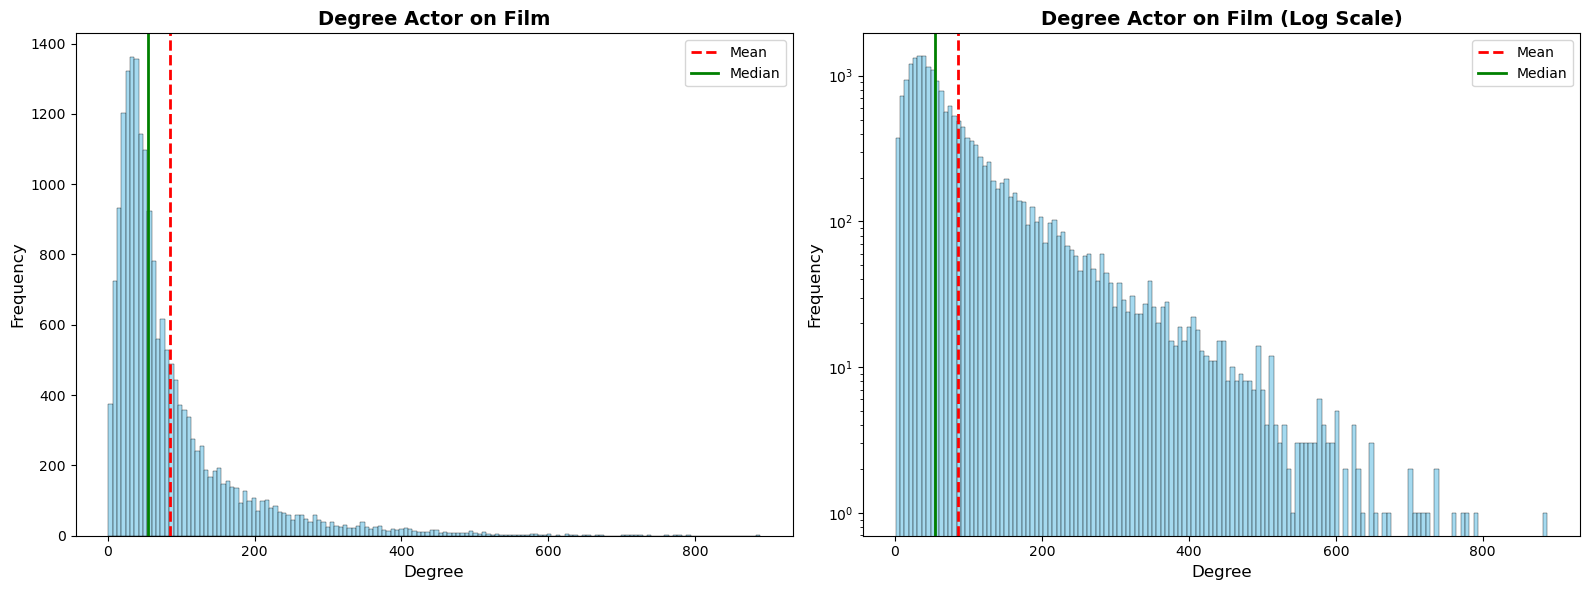

In [26]:
data = Actor_final['Degree_final'].dropna()

# mean and median
mean_degree = np.mean(data)
median_degree = np.median(data)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Actor Degree (linear scale)
sns.histplot(data, bins=150, color='skyblue', ax=axes[0])
axes[0].axvline(mean_degree, color='red', linestyle='--', linewidth=2, label='Mean')
axes[0].axvline(median_degree, color='green', linestyle='-', linewidth=2, label='Median')
axes[0].set_title('Degree Actor on Film', fontsize=14, fontweight="bold")
axes[0].set_xlabel('Degree', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].legend(fontsize=10)

# Actor Degree (log scale)
sns.histplot(data, bins=150, color='skyblue', ax=axes[1])
axes[1].axvline(mean_degree, color='red', linestyle='--', linewidth=2, label='Mean')
axes[1].axvline(median_degree, color='green', linestyle='-', linewidth=2, label='Median')
axes[1].set_yscale('log')
axes[1].set_title('Degree Actor on Film (Log Scale)', fontsize=14, fontweight="bold")
axes[1].set_xlabel('Degree', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].legend(fontsize=10)

# Plot
plt.tight_layout()
plt.show()

In [27]:
# Computing and plotting some statistical values
print('Describe of the degree of actor on film')
print(Actor_final['Degree_final'].describe())

Describe of the degree of actor on film
count    19181.000000
mean        85.245191
std         88.467410
min          1.000000
25%         32.000000
50%         55.000000
75%        104.000000
max        888.000000
Name: Degree_final, dtype: float64


In order to put this number into perspective, we can compute the average number of actors per movies and then multiply this number by the number of films played by each actor and see if this values is similar or not to the degree of an actor. Theoritically, it should be, as an actor gains an edge with another actor for each movie they played together.  

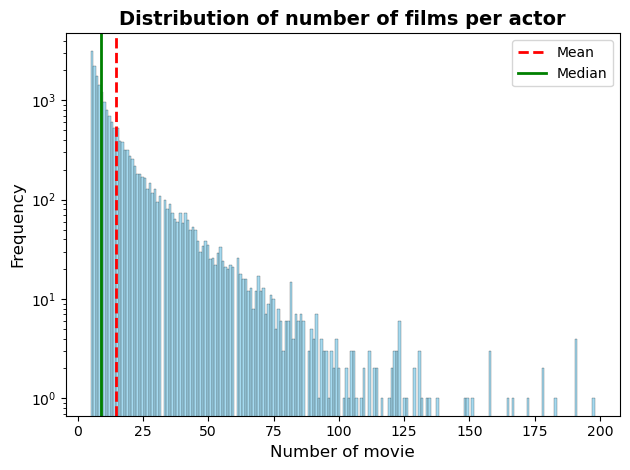

Describe of the degree of actor on film
count    19181.000000
mean        85.245191
std         88.467410
min          1.000000
25%         32.000000
50%         55.000000
75%        104.000000
max        888.000000
Name: Degree_final, dtype: float64
--------------
Describe of the number of films per actor
count    19201.000000
mean        14.766314
std         16.612596
min          5.000000
25%          6.000000
50%          9.000000
75%         17.000000
max        791.000000
Name: Number_of_films, dtype: float64


In [28]:
# mean and median
mean_actor = np.mean(Actor_final["Number_of_films"])
median_actor = np.median(Actor_final["Number_of_films"])

# Actor age at movie release
sns.histplot(Actor_final[Actor_final['Number_of_films']<200]['Number_of_films'], bins=200, color='skyblue')
plt.yscale('log')
plt.axvline(mean_actor, color='red', linestyle='--', linewidth=2, label='Mean')
plt.axvline(median_actor, color='green', linestyle='-', linewidth=2, label='Median')
plt.title('Distribution of number of films per actor',fontsize=14, fontweight="bold")
plt.xlabel('Number of movie',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.legend(fontsize=10)


# Show the plot
plt.tight_layout()
plt.show()

# Computing and plotting some statistical values
print('Describe of the degree of actor on film')
print(Actor_final['Degree_final'].describe())
print('--------------')
print('Describe of the number of films per actor')
print(Actor_final['Number_of_films'].describe())

We only plot the people with less than 200 films played or directed as there are outliers with almost 800 movies played. As can be seen from the describe of the actor above, the mean is is almost equal to 75 % quartile. This is due to the outliers (the maximum is 791) and the fact that the actors with less than 5 movies were not taken into account (they represented 85% of the original datasets). We can now analyse the relationship between degree of an actor and the mean number of movies per actor and the mean number of actors per movies.

In [29]:
Mean_degree = Actor_final['Degree_final'].mean()

# Computing different mean (per actor, per movie)
print(f'Mean degree of actor : {Mean_degree:.2f}')
print(f'Mean number of actor per movie for all movies : {Mean_actor_per_movie(Actor):.2f}')
print(f'Mean number of movies per actor for all actors : {Mean_movie_per_actor(Actor):.2f}')
print(f'Mean number of movies per actor for actors that have played at least 5 movies : {Mean_movie_per_actor(Actor_final):.2f}')
print(f'Median number of movies per actor for actors that have played at least 5 movies : 9')

print('------------')

# Computing and printing statistical values from the describe above with the mean
print(f'Mean degree of actor divided by mean number of actor per movie for all movies : {Mean_degree/Mean_actor_per_movie(Actor):.2f}')
print(f'Mean number of actor per movie for all movies multiplied by the mean number of movies per actor (5 movies) : {Mean_actor_per_movie(Actor)*Mean_movie_per_actor(Actor_final):.2f}')
print(f'Mean number of actor per movie for all movies multiplied by the median of the number of movies per actor (5 movies) : {Mean_actor_per_movie(Actor)*9:.2f}')

Mean degree of actor : 85.25
Mean number of actor per movie for all movies : 7.00
Mean number of movies per actor for all actors : 3.31
Mean number of movies per actor for actors that have played at least 5 movies : 14.77
Median number of movies per actor for actors that have played at least 5 movies : 9
------------
Mean degree of actor divided by mean number of actor per movie for all movies : 12.19
Mean number of actor per movie for all movies multiplied by the mean number of movies per actor (5 movies) : 103.29
Mean number of actor per movie for all movies multiplied by the median of the number of movies per actor (5 movies) : 62.96


As can be seen from the results above, by computing the mean number of movies played by actors by dividing the mean degree of actors by the mean number of actors per movie, we obtain 12.19. This number is below the mean number of movies played by actors, which is 14.77. However, by computing the expected degrees of an actor by multiplying the average number of movies for actors by the average number of actors per movies, we obtain 103.29 which is far superior of the actual average of 85.25. </br>
Finally, it was decided to keep the actors which played in at least 12 movies. The mean of 14.79 seems to be too strict as it is greatly influenced by outliers. Hence, as 12.19 is a combinaison of the mean degrees of actors and the mean number of number of actor per movies, this is a good balance between imposing a minimal number of movies and of "connections" in the film industry.

### 3.2 Eigenvector centrality

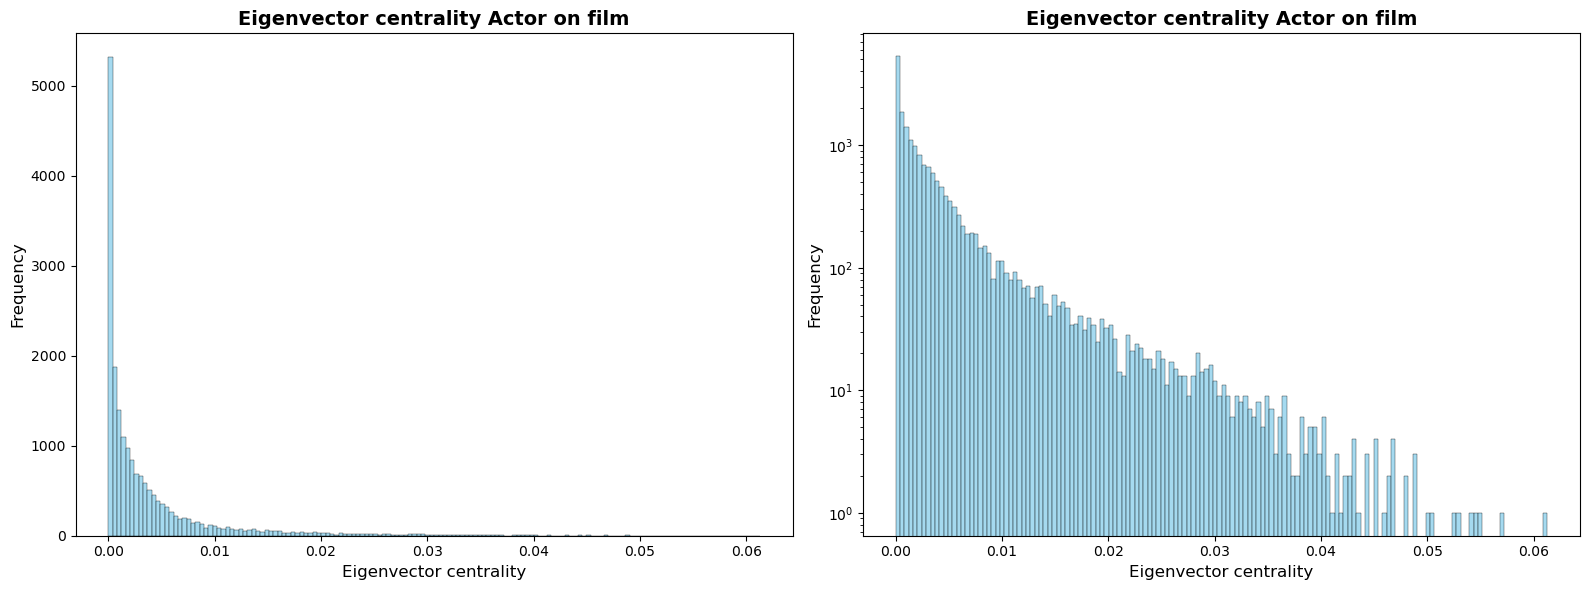

In [30]:
# Set the figure and subplots layout
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Eigenvector centrality 
sns.histplot(Actor_final['eigenvector_centrality_final'].dropna(), bins=150, color='skyblue', ax=axes[0])
axes[0].set_title('Eigenvector centrality Actor on film',fontsize=14, fontweight="bold")
axes[0].set_xlabel('Eigenvector centrality',fontsize=12)
axes[0].set_ylabel('Frequency',fontsize=12)

# Eigenvector centrality log scale
sns.histplot(Actor_final['eigenvector_centrality_final'].dropna(), bins=150, color='skyblue', ax=axes[1])
axes[1].set_yscale('log')
axes[1].set_title('Eigenvector centrality Actor on film',fontsize=14, fontweight="bold")
axes[1].set_xlabel('Eigenvector centrality',fontsize=12)
axes[1].set_ylabel('Frequency',fontsize=12)

# Plot
plt.tight_layout()
plt.show()

In [31]:
print('Describe of the eigenvector centrality of actor on film')
print(Actor_final['eigenvector_centrality_final'].describe())

Describe of the eigenvector centrality of actor on film
count    1.918100e+04
mean     3.845203e-03
std      6.111570e-03
min      5.451052e-47
25%      3.346270e-04
50%      1.599332e-03
75%      4.473047e-03
max      6.130016e-02
Name: eigenvector_centrality_final, dtype: float64


The values of the eigenvector centrality are really small. The mean is almost 0.0038 and the median 0.00158 for actors with at least 5 movies. Even by taking into account only the actors which played in at least 50 movies, the values did not changed significantly. A potentiel explanation is the fact that, as seen previously from the adjacency matrix in section 2.1, the network is subdivided into two regions (dire as was seen dans la partie d'émile que ça peut être plusieurs clusters). This two regions are the European/American film industry and the Indian film industry. Both are communities that are large in size but never or rarely work together. Consequently, the overall eigenvector is low. 


A possible fix to this problem would be to separate the networks into multiple networks and compute the centrality of each of the networks and to keep the centrality above a certain value (relative to its network). Later on, the criteria on the eigenvector centrality would be applied separately on each region in order to determine which actor is successful.</br>
This method was tried by separating the networks but was not successful, it was then decided to try Louvain method to determine communities among the networks.

In [32]:
# Computing the community of the network of actors
actors_clustered, largest_clusters = Splitting_Louvain(played_together,Actor_final)

# Computing the centrality of each actors with respect to their community and their separeted network
Actors_Groups, Networks = Centrality_Louvain(actors_clustered,largest_clusters,Movie)

Creating network: 100%|████████████████| 20027/20027 [00:01<00:00, 16937.07it/s]
Adding attributes: 99888it [00:04, 24111.55it/s]
Creating network: 100%|████████████████| 16525/16525 [00:01<00:00, 15059.39it/s]
Adding attributes: 55923it [00:02, 23507.00it/s]
Creating network: 100%|████████████████| 11759/11759 [00:00<00:00, 23829.79it/s]
Adding attributes: 33045it [00:01, 24456.26it/s]
Creating network: 100%|██████████████████| 9996/9996 [00:00<00:00, 24359.28it/s]
Adding attributes: 25875it [00:01, 23717.32it/s]
Creating network: 100%|██████████████████| 9046/9046 [00:00<00:00, 19852.78it/s]
Adding attributes: 44401it [00:01, 24580.65it/s]
Creating network: 100%|██████████████████| 3772/3772 [00:00<00:00, 25330.53it/s]
Adding attributes: 11612it [00:00, 23813.19it/s]
Creating network: 100%|██████████████████| 2989/2989 [00:00<00:00, 27648.33it/s]
Adding attributes: 7770it [00:00, 23417.50it/s]
Creating network: 100%|████████████████████| 505/505 [00:00<00:00, 24295.14it/s]
Adding att

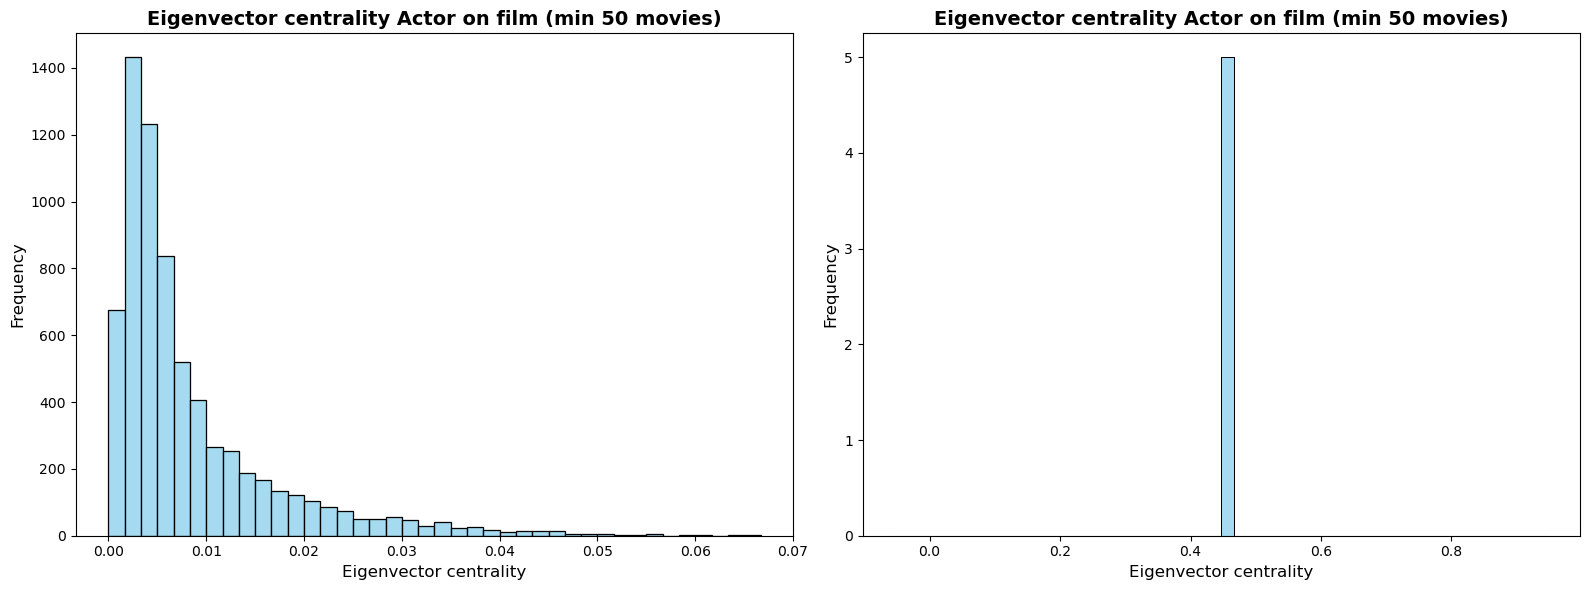

In [33]:
# Set the figure and subplots layout
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Eigenvector centrality 
sns.histplot(Actors_Groups['cluster_1']['eigenvector_centrality_final'].dropna(), bins=40, color='skyblue', ax=axes[0])
axes[0].set_title('Eigenvector centrality Actor on film (min 50 movies)',fontsize=14, fontweight="bold")
axes[0].set_xlabel('Eigenvector centrality',fontsize=12)
axes[0].set_ylabel('Frequency',fontsize=12)

# Eigenvector centrality log scale
sns.histplot(Actors_Groups['cluster_12']['eigenvector_centrality_final'].dropna(), bins=50, color='skyblue', ax=axes[1])
axes[1].set_title('Eigenvector centrality Actor on film (min 50 movies)',fontsize=14, fontweight="bold")
axes[1].set_xlabel('Eigenvector centrality',fontsize=12)
axes[1].set_ylabel('Frequency',fontsize=12)

# Plot
plt.tight_layout()
plt.show()

As can be seen from above, the eigenvector centrality did change for some of the communities but not for all. This is still better than just taking the top 50% centrality or the values above the mean. Indeed, as we have a "relative" centrality, we take into account the people which are the best among their close circle of actors. Nevertheless, we should verify what actors will be dropped. If in the end, a community of only successful actors was build and we drop 50% of it, it does not make sense with our study. 

In [34]:
# Computing the actors that are above the mean or the median of the eigenvector centrality of all actors
Keep_Mean, Keep_Median = Eigenvector_Mean_Median(Actor_final)

In [35]:
# Computing the actors that are above the mean centrality of their community made by Louvain's method
Top_Louvain_Centrality = Top_centrality_Louvain(Actors_Groups)

In [36]:
# Creating a list of all the index of actors from the Louvain method that are above the mean centrality of their group
Louvain_method = 0
keep_list_Louvain = []
for cluster, actor in Top_Louvain_Centrality.items():
    Louvain_method = actor.shape[0] + Louvain_method
    keep_list_Louvain.extend(actor['Freebase_actor_ID'].tolist())

# Comparing which actors have been taken for each method
MeanVsMethod2 = Keep_Mean['Freebase_actor_ID'].isin(keep_list_Louvain)
MedianVsMethod2 = Keep_Median['Freebase_actor_ID'].isin(keep_list_Louvain)
keep_list_Louvain_df = pd.DataFrame(keep_list_Louvain,columns=['Freebase_actor_ID'])
Method2VsMedian = keep_list_Louvain_df['Freebase_actor_ID'].isin(Keep_Median['Freebase_actor_ID'])

In [37]:
# Printing the result
print(f"Number of actors which are above the global mean of the eigenvector centrality : {Keep_Mean.shape[0]}")
print(f"Number of actors which are above the global median of the eigenvector centrality : {Keep_Median.shape[0]}")
print(f"Number of actors which are above the mean of their community eigenvector centrality : {Louvain_method}")

# Printing the comparaison
print('------------')
print(f"Number of actors which are above the global mean but not above their community mean :")
print(f"{MeanVsMethod2.value_counts()}")
print('------------')
print(f"Number of actors which are above the global median but not above their community mean :")
print(f"{MedianVsMethod2.value_counts()}")
print('------------')
print(f"Number of actors which are above their community mean but not above the global median :")
print(f"{Method2VsMedian.value_counts()}")

Number of actors which are above the global mean of the eigenvector centrality : 5534
Number of actors which are above the global median of the eigenvector centrality : 9591
Number of actors which are above the mean of their community eigenvector centrality : 6357
------------
Number of actors which are above the global mean but not above their community mean :
Freebase_actor_ID
True     3419
False    2115
Name: count, dtype: int64
------------
Number of actors which are above the global median but not above their community mean :
Freebase_actor_ID
False    5161
True     4430
Name: count, dtype: int64
------------
Number of actors which are above their community mean but not above the global median :
Freebase_actor_ID
True     4430
False    1927
Name: count, dtype: int64


As can be seen from the results above, around 40% of actors which were above the global mean of the centrality are not above the mean of their community. This is a problem, the Louvain method potentially created communities of "succesful" actors, hence half of those were drop in the process. Consequently, it was decided to take the global mean as a criteria, instead of the mean per communities.

### 3.3 Ratings and genres

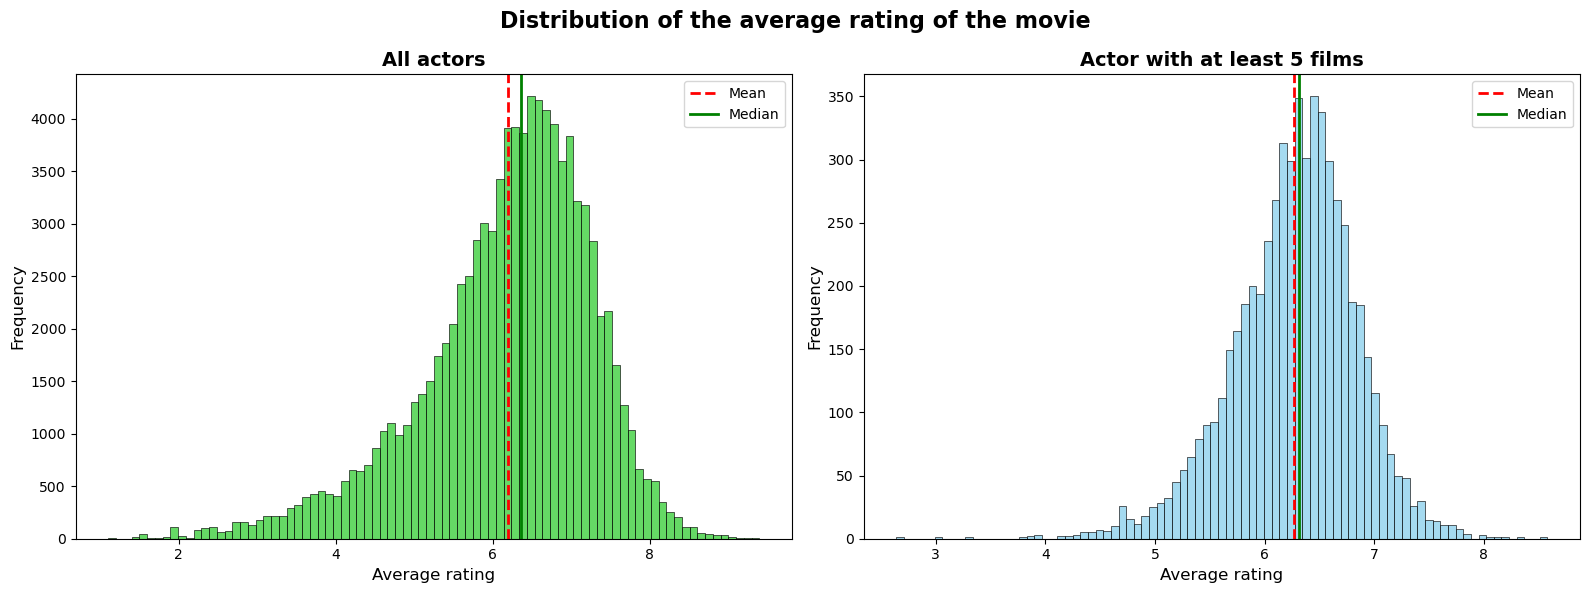

Describe of the actor rating for all actors
count    95338.000000
mean         6.193567
std          1.107457
min          1.100000
25%          5.600000
50%          6.366667
75%          6.982955
max          9.400000
Name: Mean_Rating, dtype: float64
------------
Describe of the actor rating for actors with more than 5 movies
count    5917.000000
mean        6.270479
std         0.565420
min         2.640000
25%         5.937500
50%         6.316667
75%         6.633333
max         8.580000
Name: Mean_Rating, dtype: float64


In [38]:
# mean and median
mean_actor = np.mean(Actor['Mean_Rating'].dropna())
median_actor = np.median(Actor['Mean_Rating'].dropna())

mean_actor_5 = np.mean(Actor_final['Mean_Rating'].dropna())
median_actor_5 = np.median(Actor_final['Mean_Rating'].dropna())

# Set the figure and subplots layout
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Actor average rating per movie
sns.histplot(Actor['Mean_Rating'].dropna(), bins=84, color='limegreen', ax=axes[0])
axes[0].axvline(mean_actor, color='red', linestyle='--', linewidth=2, label='Mean')
axes[0].axvline(median_actor, color='green', linestyle='-', linewidth=2, label='Median')
axes[0].set_title('All actors',fontsize=14, fontweight="bold")
axes[0].set_xlabel('Average rating',fontsize=12)
axes[0].set_ylabel('Frequency',fontsize=12)
axes[0].legend(fontsize=10)

# Actor with at lest 5 films average rating per movie
sns.histplot(Actor_final['Mean_Rating'].dropna(), bins=85, color='skyblue', ax=axes[1])
axes[1].axvline(mean_actor_5, color='red', linestyle='--', linewidth=2, label='Mean')
axes[1].axvline(median_actor_5, color='green', linestyle='-', linewidth=2, label='Median')
axes[1].set_title('Actor with at least 5 films',fontsize=14, fontweight="bold")
axes[1].set_xlabel('Average rating',fontsize=12)
axes[1].set_ylabel('Frequency',fontsize=12)
axes[1].legend(fontsize=10)

plt.suptitle('Distribution of the average rating of the movie', fontsize=16, fontweight="bold")

# Plot
plt.tight_layout()
plt.show()

print('Describe of the actor rating for all actors')
print(Actor['Mean_Rating'].describe())
print('------------')
print('Describe of the actor rating for actors with more than 5 movies')
print(Actor_final['Mean_Rating'].describe())

It is interesting to notice that by taking into account only the actors with at least 5 movies, the ratings concentrate their values around the mean as there are leass rating above 7 and especially almost none below 5. This suggest that actors throughout their career have up and downs. Indeed, as they have done more films, their average ratings "stabilize" around the mean/median, as expected from a large number of films.</br>
Moreover, actors with longer careers, as expected, have better and more constant ratings. Indeed, 50% of the ratings are between 5.93 and 6.63. The mean and the median are closer also while only taking actors with more than 5 films. This motivate once more the fact to drop actors with less than a certain amounts of movies.

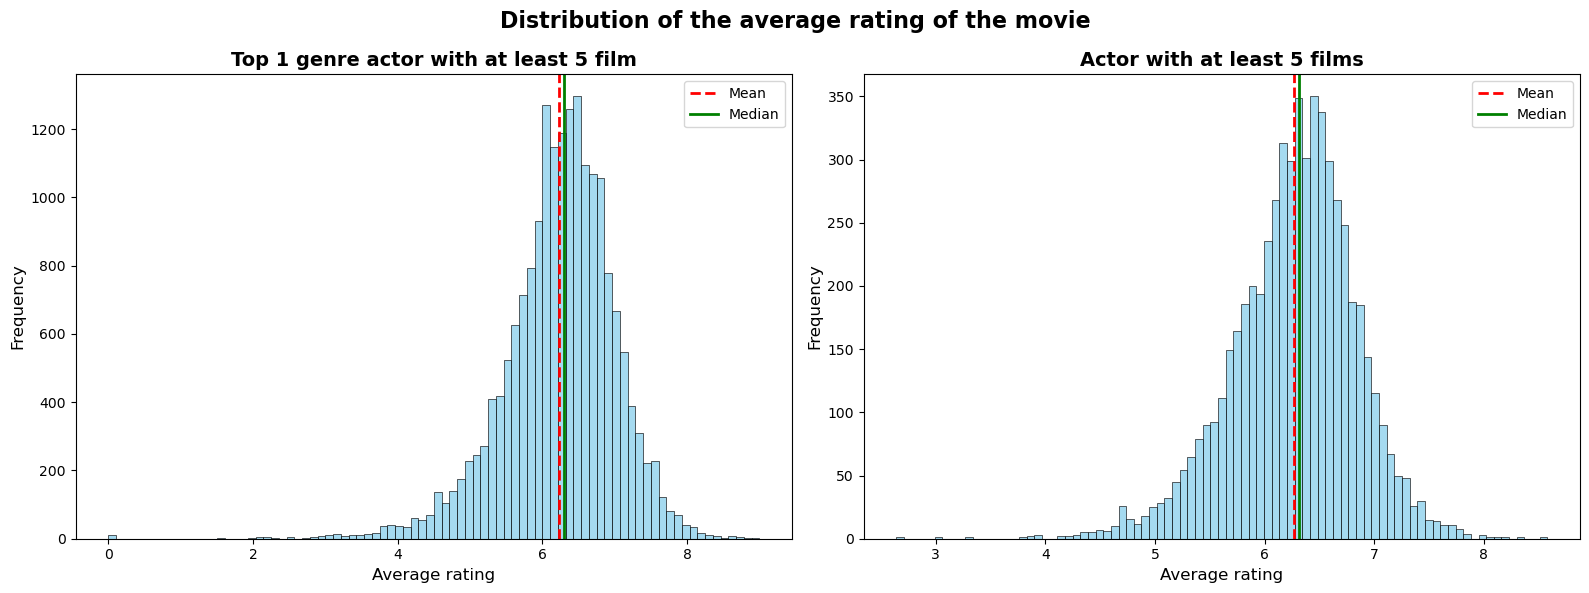

Mean of ratings of actor per genre : 6.231
Mean of ratings of actor : 6.270
Median of ratings of actor per genre : 6.300
Median of ratings of actor : 6.317


In [39]:
# mean and median
mean_actor_genre = np.mean(Actor_final['Top_1_Rating'].dropna())
median_actor_genre = np.median(Actor_final['Top_1_Rating'].dropna())

mean_actor_5 = np.mean(Actor_final['Mean_Rating'].dropna())
median_actor_5 = np.median(Actor_final['Mean_Rating'].dropna())

# Set the figure and subplots layout
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Actor average rating per movie
sns.histplot(Actor_final['Top_1_Rating'].dropna(), bins=84, color='skyblue', ax=axes[0])
axes[0].axvline(mean_actor_genre, color='red', linestyle='--', linewidth=2, label='Mean')
axes[0].axvline(median_actor_genre, color='green', linestyle='-', linewidth=2, label='Median')
axes[0].set_title('Top 1 genre actor with at least 5 film',fontsize=14, fontweight="bold")
axes[0].set_xlabel('Average rating',fontsize=12)
axes[0].set_ylabel('Frequency',fontsize=12)
axes[0].legend(fontsize=10)

# Actor with at lest 5 films average rating per movie
sns.histplot(Actor_final['Mean_Rating'].dropna(), bins=85, color='skyblue', ax=axes[1])
axes[1].axvline(mean_actor_5, color='red', linestyle='--', linewidth=2, label='Mean')
axes[1].axvline(median_actor_5, color='green', linestyle='-', linewidth=2, label='Median')
axes[1].set_title('Actor with at least 5 films',fontsize=14, fontweight="bold")
axes[1].set_xlabel('Average rating',fontsize=12)
axes[1].set_ylabel('Frequency',fontsize=12)
axes[1].legend(fontsize=10)

plt.suptitle('Distribution of the average rating of the movie', fontsize=16, fontweight="bold")

# Plot
plt.tight_layout()
plt.show()

print(f"Mean of ratings of actor per genre : {mean_actor_genre:.3f}")
print(f"Mean of ratings of actor : {mean_actor_5:.3f}")
print(f"Median of ratings of actor per genre : {median_actor_genre:.3f}")
print(f"Median of ratings of actor : {median_actor_5:.3f}")

The graph are very similar as expected. Indeed, the median and the mean are similar in both cases. Nevertheless, they are in both cases lower than than if we took into account all the ratings of the actors. 

In [40]:
print(f"Describe of all genres : {Genre_counts['Average rating'].describe()}")
print('---------------')
print(f"Describe of genres with more than 200 movies : {Genre_counts_200['Average rating'].describe()}")

Describe of all genres : count    361.000000
mean       6.392463
std        0.646262
min        4.000000
25%        6.050000
50%        6.420000
75%        6.820000
max        8.100000
Name: Average rating, dtype: float64
---------------
Describe of genres with more than 200 movies : count    94.000000
mean      6.263484
std       0.474508
min       4.495300
25%       6.031623
50%       6.311633
75%       6.521556
max       7.285877
Name: Average rating, dtype: float64


A similar observation can be made for the genre. By taking into account less genre, the overall ratings concentrate around 6 to 6.5. In addition to that, the mean drop by 0.13 and the median by 0.11 which is also interesting. 

### 3.4 Determine the successfull actors

Now that the metrics were anaysed, we can finally determine the criteria that we will used to decide if an actor is successful or not. This criteria are of course arbitrary an if more/different information were available, they would potentially have changed. Here is the list :
- Edge and number of films per actor : actors which played in at least 12 movies will be kept.
- Ratings : actors wich are above the average ratings of their genre will be kept.
- Centrality : actors wich are above the mean centrality of all actors will be kept.

As a consequence, almost half of the actors, even more potentially, will be dropped. This was to be expected and necessary, as the successful actors shoudl theoritically only be among the top 5% of all actors. Indeed, at the beginning we dropped 85% of the actors that we originally had, hence only keeping 15%. By dropping more than half of the remaining actors, we will keep the top 5%. This top 5% is arbitrary, as explained previously, it depends on our expectations of what is successful. For our group, being successful means being in the top, even by taking 5% we may be laxist as we could only take the top 1%. However, as our dataset only contains 80'000 films and 135'000 which do not represent the millions of films that have been made, we can not be sure that we do not already have a pre-process dataset of "successfull movies", hence keeping more is a valid choice. In addition to that, the less actors we keep, the less data we have to analyse.

In [41]:
# Applying the criteria on the Rating
Actor_TOP_RATING, keep = keep_above_mean_rating(Actor_final,Genre_counts_200)
print(f"{Actor_final.shape[0]-Actor_TOP_RATING.shape[0]} actors are dropped due to their average rating")

Checking their relative ranking: 19201it [00:59, 323.59it/s]

8472 actors are dropped due to their average rating


In [42]:
# Applying the criteria on the number of film 
Actor_12_MOVIES = Actor_final[Actor_final['Number_of_films'] >= 12]
print(f"{Actor_final.shape[0]-Actor_12_MOVIES.shape[0]} actors are dropped due to the number of films played")

11575 actors are dropped due to the number of films played


In [43]:
# Applying the criteria on the centrality
Actor_TOP_Mean_centraty, _ = Eigenvector_Mean_Median(Actor_final)
print(f"{Actor_final.shape[0]-Actor_TOP_Mean_centraty.shape[0]} actors are dropped due to their centrality")

13667 actors are dropped due to their centrality


In [44]:
# Comparing which actors have been droppped for each criteria
NumberFilmsVsRating = Actor_12_MOVIES['Freebase_actor_ID'].isin(Actor_TOP_RATING['Freebase_actor_ID'])
CentralityVsRating = Actor_TOP_Mean_centraty['Freebase_actor_ID'].isin(Actor_TOP_RATING['Freebase_actor_ID'])
CentralityVsNumberFilms = Actor_TOP_Mean_centraty['Freebase_actor_ID'].isin(Actor_12_MOVIES['Freebase_actor_ID'])


# Printing the comparaison
print(f"Actors which have played 12 films and are (or not) above their genre average rating:")
print(f"{NumberFilmsVsRating.value_counts()}")
print('------------')
print(f"Actors above the global mean average and are (or not) above their genre average rating:")
print(f"{CentralityVsRating.value_counts()}")
print('------------')
print(f"Actors above the global mean average and have (or not) played in at least 12 films:")
print(f"{CentralityVsNumberFilms.value_counts()}")

Actors which have played 12 films and are (or not) above their genre average rating:
Freebase_actor_ID
True     4475
False    3151
Name: count, dtype: int64
------------
Actors above the global mean average and are (or not) above their genre average rating:
Freebase_actor_ID
True     3110
False    2424
Name: count, dtype: int64
------------
Actors above the global mean average and have (or not) played in at least 12 films:
Freebase_actor_ID
True     3980
False    1554
Name: count, dtype: int64


In [45]:
# Compiling each of the different criteria
Actor_Success2 = keep_successful_actor(Actor_final, Genre_counts_200)
print(f"In total there is {Actor_Success2.shape[0]} which are successful based on our criteria")

Checking their relative ranking: 19201it [01:01, 314.14it/s]

In total there is 2316 which are successful based on our criteria


## 4. Actors and directors networks

Now that the selection fo successful actors was made based on the different criteria, it is possible to create the bipartite directed graph between them and the director. The objective will be to create a bipartite directed that begin from the actors and go to the directors. A edge between an actor and a director is only possible if they worked together and the weight of the edge represent the number of films on which they worked together. The final value at the node of each director is the sum of the weight of all edges coming to him. 

In [46]:
# Create the network using a function we programmed
Di_B_network = create_Directed_bipartite_network_actor_director(Actor_Success2, Director, min_movies=10)

# Remove the nodes that are nans                
nan_nodes = [node for node in Di_B_network.nodes if pd.isna(node)] 
Di_B_network.remove_nodes_from(nan_nodes)

# Verify the form of the graph
is_bipartite = nx.is_bipartite(Di_B_network)
print("Is the graph bipartite?", is_bipartite)

is_directed = nx.is_directed(Di_B_network)
print("Is the graph directed?", is_directed)

Nodes for actors: 2316it [00:00, 21361.21it/s]
Nodes for directors: 20181it [00:00, 24077.23it/s]
Edges of network: 74624it [00:03, 21084.14it/s]
Adding actors attributes: 2316it [00:00, 18256.81it/s]
Adding directors attributes: 20181it [00:00, 22567.13it/s]
Computing weights for directors: 100%|████| 7260/7260 [00:06<00:00, 1153.88it/s]

Is the graph bipartite? True
Is the graph directed? True


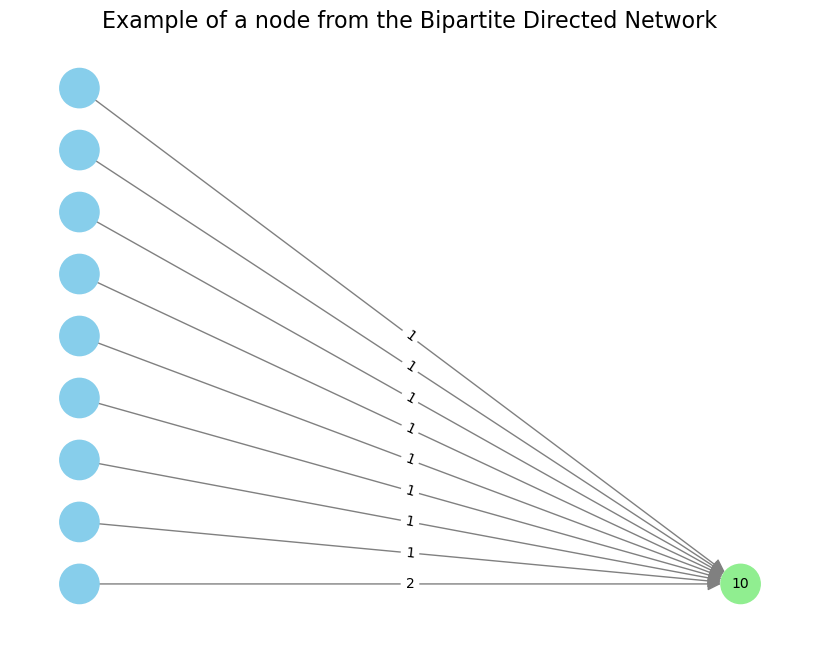

In [47]:
_, nodes_director = nx.bipartite.sets(Di_B_network) 

director_node='nm0627864'

# Compute the actor connected to the director 
Actors_nodes = list(Di_B_network.predecessors(director_node))  
nodes = [director_node] + Actors_nodes
subgraph = Di_B_network.subgraph(nodes)

pos_sub = nx.bipartite_layout(subgraph, Actors_nodes)

# Draw the graph
plt.figure(figsize=(8, 6))
labels_node = {n: subgraph.nodes[n]['weight'] if n == director_node else '' for n in subgraph.nodes}
labels_edge = {e: subgraph.edges[e]['weight'] for e in subgraph.edges}
nx.draw(subgraph, pos_sub, with_labels=True, node_color=['skyblue' if node in Actors_nodes else 'lightgreen' for node in subgraph.nodes()],  
        arrowsize=20, edge_color='gray', node_size=800, font_size=10, 
        labels=labels_node
       )
plt.title("Example of a node from the Bipartite Directed Network", fontsize=16)
nx.draw_networkx_edge_labels(subgraph, pos_sub, edge_labels=labels_edge)
plt.show()

In [48]:
def director_success1(Network, Director):
    # Computes the actor and director part of network
    nodes_actor, nodes_director = nx.bipartite.sets(Network)
    
    # Only keep the director part of the network
    Director_Success = Director[Director['IMDb_director_ID'].isin(nodes_director)].copy()
    Director_Success['Freebase_actor_ID'] = None  
    Director_Success['Weight'] = None  
    Director_Success['Sum_Weight'] = 0  
    Director_Success["Number_of_actors"] = None

    # Compute the weight, total weight and the actor wich worked under the director for each director
    for director in tqdm(nodes_director, desc="Extracting attributes for directors"):
        Actor_ID = []
        Weight = []
        Sum_Weight = 0
        for actor in nodes_actor:
            edge_data = Network.get_edge_data(actor, director)
            if edge_data:
                Actor_ID.append(actor)
                Weight.append(edge_data["weight"])
                Sum_Weight += edge_data["weight"]
                #Actor_ID.append(actor)
                #Weight.append(Network.get_edge_data(actor,director)["weight"])
                #Sum_Weight += Network.get_edge_data(actor,director)["weight"]

        # CA C'EST CHAT QUI M'A AIDéE PARCE QUE JE N'ARRIVAIS PAS à ARRANGER MON PROBLèME DE LIST EN UNE CELLE
        
        # Use .at to assign values to the cells as they are a list
        idx = Director_Success[Director_Success['IMDb_director_ID'] == director].index.tolist()
        idx = idx[0]
        Director_Success.at[idx, 'Freebase_actor_ID'] = Actor_ID
        Director_Success.at[idx, 'Weight'] = Weight
        Director_Success.at[idx, 'Sum_Weight'] = Sum_Weight
    
    Director_Success["Number_of_actors"] = Director_Success["Freebase_actor_ID"].apply(len)

    return Director_Success

In [49]:
# Computing the director which result from the network and adding their attributes to their profile
# Adding Weight, Total_Weight and the list of successful wich worked with them
Director_Success = director_success1(Di_B_network, Director)
Director_Success[['IMDb_director_ID','director_name','Freebase_actor_ID','Number_of_actors','Weight','Sum_Weight']].head()

Extracting attributes for directors: 100%|█| 7260/7260 [00:11<00:00, 629.88it/s]


,IMDb_director_ID,director_name,Freebase_actor_ID,Number_of_actors,Weight,Sum_Weight
0,nm0000005,Ingmar Bergman,"[/m/05r751, /m/01tj5w, /m/0bdt8, /m/01y64_, /m...",7,"[1, 1, 2, 1, 1, 10, 9]",25
1,nm0000008,Marlon Brando,"[/m/0js45, /m/04__f, /m/01y8cr, /m/028lc8, /m/...",5,"[1, 1, 1, 1, 1]",5
2,nm0000009,Richard Burton,"[/m/0bmh4, /m/0cg9f]",2,"[1, 1]",2
3,nm0000018,Kirk Douglas,"[/m/0j582, /m/0n7f, /m/01rnxn, /m/026sv79, /m/...",6,"[1, 1, 1, 1, 1, 1]",6
4,nm0000019,Federico Fellini,"[/m/01tt43d, /m/01479s, /m/01fkv0, /m/0b_fw, /...",17,"[1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",23


## 5. Most highly valued director

Now that the director related to the successful actors were determined, it is possible to sort them based on their total weight. The computation is straight-forward.

In [50]:
Director_Success.sort_values(by=['Sum_Weight'], inplace=True, ascending=False)
Director_Success[['IMDb_director_ID','director_name','Freebase_actor_ID','Number_of_actors','Weight','Sum_Weight']].head()

,IMDb_director_ID,director_name,Freebase_actor_ID,Number_of_actors,Weight,Sum_Weight
25,nm0000095,Woody Allen,"[/m/067187, /m/014g22, /m/01tt43d, /m/02bj6k, ...",204,"[1, 1, 1, 1, 4, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, ...",302
502,nm0002031,Michael Curtiz,"[/m/0197p7, /m/0j582, /m/01bh6y, /m/0132f1, /m...",112,"[2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9, 3, 1, 5, ...",218
121,nm0000406,John Ford,"[/m/015rhv, /m/054ztz, /m/02f6s3, /m/029135, /...",99,"[1, 1, 2, 1, 1, 1, 1, 2, 1, 22, 7, 2, 1, 1, 1,...",209
6442,nm0368871,Henry Hathaway,"[/m/0gqp2d, /m/06mr6, /m/0j582, /m/015rhv, /m/...",144,"[1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 8, 2, 1, 7, ...",205
76,nm0000229,Steven Spielberg,"[/m/01yk13, /m/07d3z7, /m/02bj6k, /m/0nqls, /m...",165,"[1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 3, 1, 2, 1, ...",192


## 6. Analyse and compare the directors between them

In this section, we will compare the previously selected directors. Multiple parameters will be used such as weight, total weight, number of successful actors, number of movie directed, average ratings of them and their actors, etc.</br>

aussi regarder career start age, date de naissance, genre de film,fréquence de film ?????, ....


The goal will then be to analyse to similarities and differences and potentially to define different type of directors based on our findings. In addition to that, the link between these directors and the successful actors will also be investigate. 

à faire :
- lien entre la période de vie et l'évolution dans la manière de faire des films

In [51]:
print(f"Total number of director that are linked to successful actors : {Director_Success.shape[0]}")

Total number of director that are linked to successful actors : 7260


/var/folders/37/w8_bl_xd53n7dlt9q3m5v8vm0000gn/T/ipykernel_33704/1393539386.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(fontsize=10)


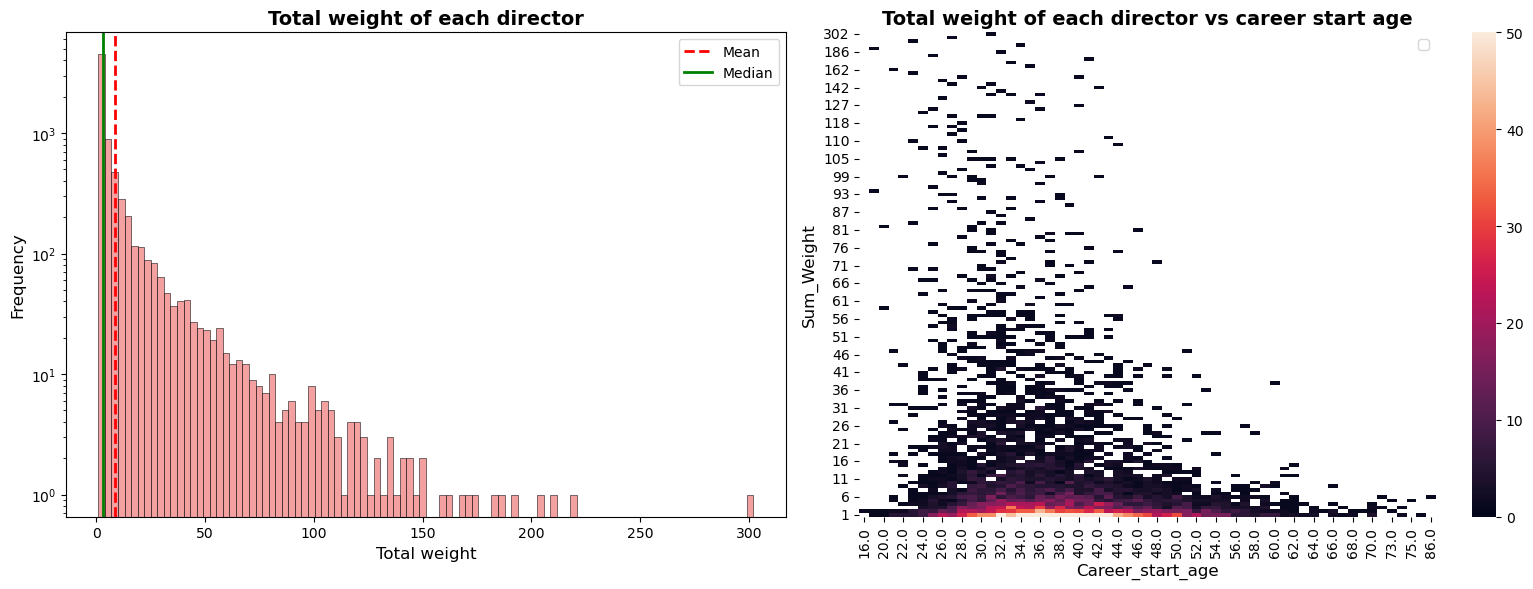

In [52]:
# mean and median
mean_Sum_Weight = np.mean(Director_Success['Sum_Weight'].dropna())
median_Sum_Weight = np.median(Director_Success['Sum_Weight'].dropna())

# Set the figure and subplots layout
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Total weight for each director
sns.histplot(Director_Success['Sum_Weight'].dropna(), bins=100, color='lightcoral', ax=axes[0])
axes[0].set_yscale('log')
axes[0].axvline(mean_Sum_Weight, color='red', linestyle='--', linewidth=2, label='Mean')
axes[0].axvline(median_Sum_Weight, color='green', linestyle='-', linewidth=2, label='Median')
axes[0].set_title('Total weight of each director',fontsize=14, fontweight="bold")
axes[0].set_xlabel('Total weight',fontsize=12)
axes[0].set_ylabel('Frequency',fontsize=12)
axes[0].legend(fontsize=10)

# Total weight for each director vs Career start age
df = pd.crosstab(Director_Success['Sum_Weight'],Director_Success['Career_Start_age'], values = Director_Success['Sum_Weight'],aggfunc='count')
sns.heatmap(df, annot=False,vmin = 0, vmax = 50, ax=axes[1])
axes[1].set_title('Total weight of each director vs career start age',fontsize=14, fontweight="bold")
axes[1].set_xlabel('Career_start_age',fontsize=12)
axes[1].set_ylabel('Sum_Weight',fontsize=12)
axes[1].invert_yaxis()
axes[1].legend(fontsize=10)

# Plot
plt.tight_layout()
plt.show()

In [53]:
print('Describe of the Sum_Weight of the director :')
print(Director_Success['Sum_Weight'].describe())

Describe of the Sum_Weight of the director :
count    7260.000000
mean        8.809366
std        17.509331
min         1.000000
25%         1.000000
50%         3.000000
75%         8.000000
max       302.000000
Name: Sum_Weight, dtype: float64


On peut voir que y'a énormément de disparité, genre vraiment bcp

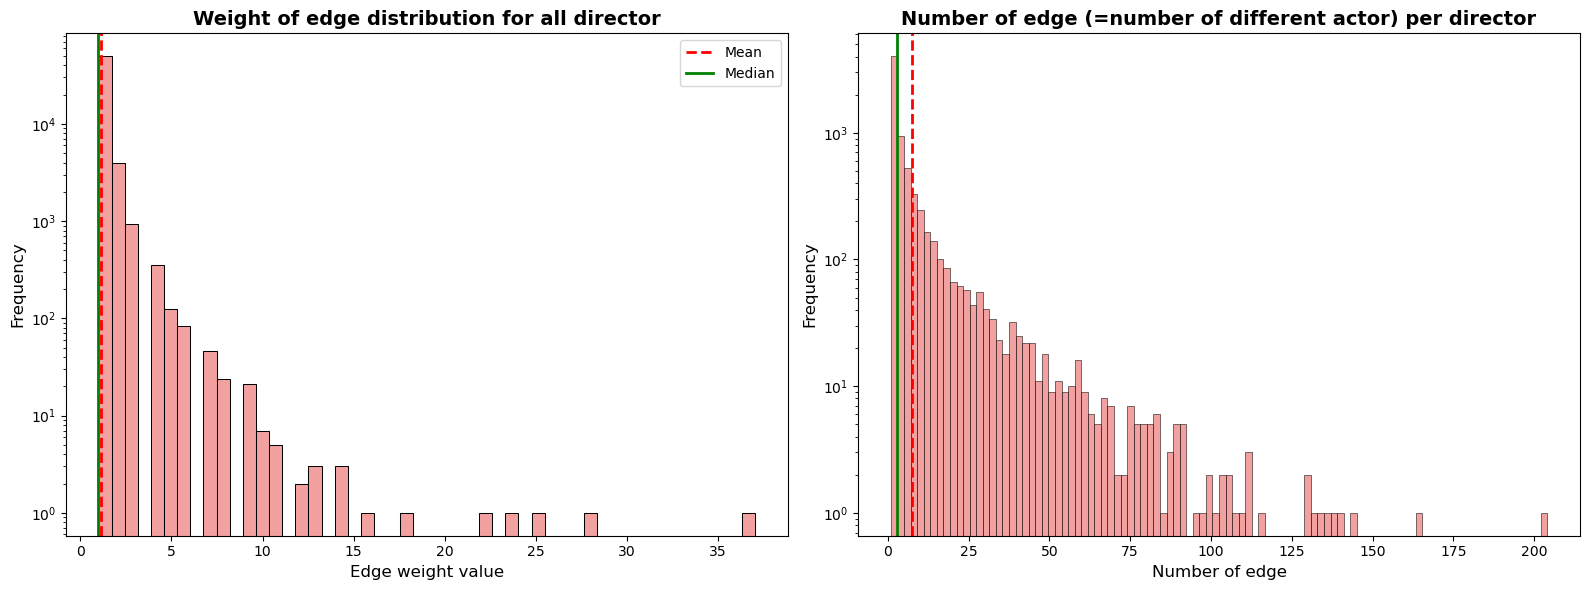

In [54]:
# Extract the weight of each edge
all_weight = [weight for weight_list in Director_Success['Weight'] for weight in weight_list]

# mean and median
mean_Sum_Weight = np.mean(all_weight)
median_Sum_Weight = np.median(all_weight)

# Set the figure and subplots layout
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Total weight for each director
sns.histplot(all_weight, bins=50, color='lightcoral', ax=axes[0])
axes[0].set_yscale('log')
axes[0].axvline(mean_Sum_Weight, color='red', linestyle='--', linewidth=2, label='Mean')
axes[0].axvline(median_Sum_Weight, color='green', linestyle='-', linewidth=2, label='Median')
axes[0].set_title('Weight of edge distribution for all director',fontsize=14, fontweight="bold")
axes[0].set_xlabel('Edge weight value',fontsize=12)
axes[0].set_ylabel('Frequency',fontsize=12)
axes[0].legend(fontsize=10)

# Total weight for each director vs Career start age

# mean and median
mean_Number_of_Actor = np.mean(Director_Success['Number_of_actors'])
median_Number_of_Actor = np.median(Director_Success['Number_of_actors'])

sns.histplot(Director_Success['Number_of_actors'], bins=100, color='lightcoral', ax=axes[1])
axes[1].set_yscale('log')
axes[1].axvline(mean_Number_of_Actor, color='red', linestyle='--', linewidth=2, label='Mean')
axes[1].axvline(median_Number_of_Actor, color='green', linestyle='-', linewidth=2, label='Median')
axes[1].set_title('Number of edge (=number of different actor) per director',fontsize=14, fontweight="bold")
axes[1].set_xlabel('Number of edge',fontsize=12)
axes[1].set_ylabel('Frequency',fontsize=12)

# Plot
plt.tight_layout()
plt.show()

In [55]:
# c'est chat qui m'a fait cette merde 
# Count each occurences for each weight

from collections import Counter 
counts = Counter(all_weight)

# Dataframe to store the results
weights_edge = pd.DataFrame(counts.items(), columns=['Weight', 'Occurrences'])
weights_edge.sort_values(by=['Weight'], inplace=True, ascending=True)

weights_edge

,Weight,Occurrences
0,1,49604
2,2,3963
3,3,924
1,4,357
4,5,125
6,6,83
7,7,46
12,8,24
9,9,21
17,10,7


In [56]:
print('Describe of the edge of the director :')
print(Director_Success['Number_of_actors'].describe())

Describe of the edge of the director :
count    7260.000000
mean        7.599725
std        13.551323
min         1.000000
25%         1.000000
50%         3.000000
75%         7.000000
max       204.000000
Name: Number_of_actors, dtype: float64


De ça on peut voir que comme prévu bcp d'acteurs travailles principalement une fois par directeur et après ils changent de directeur. Néanmoins y'a des mecs qui récidivent et qui font plusieurs

/var/folders/37/w8_bl_xd53n7dlt9q3m5v8vm0000gn/T/ipykernel_33704/2311087830.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(fontsize=10)


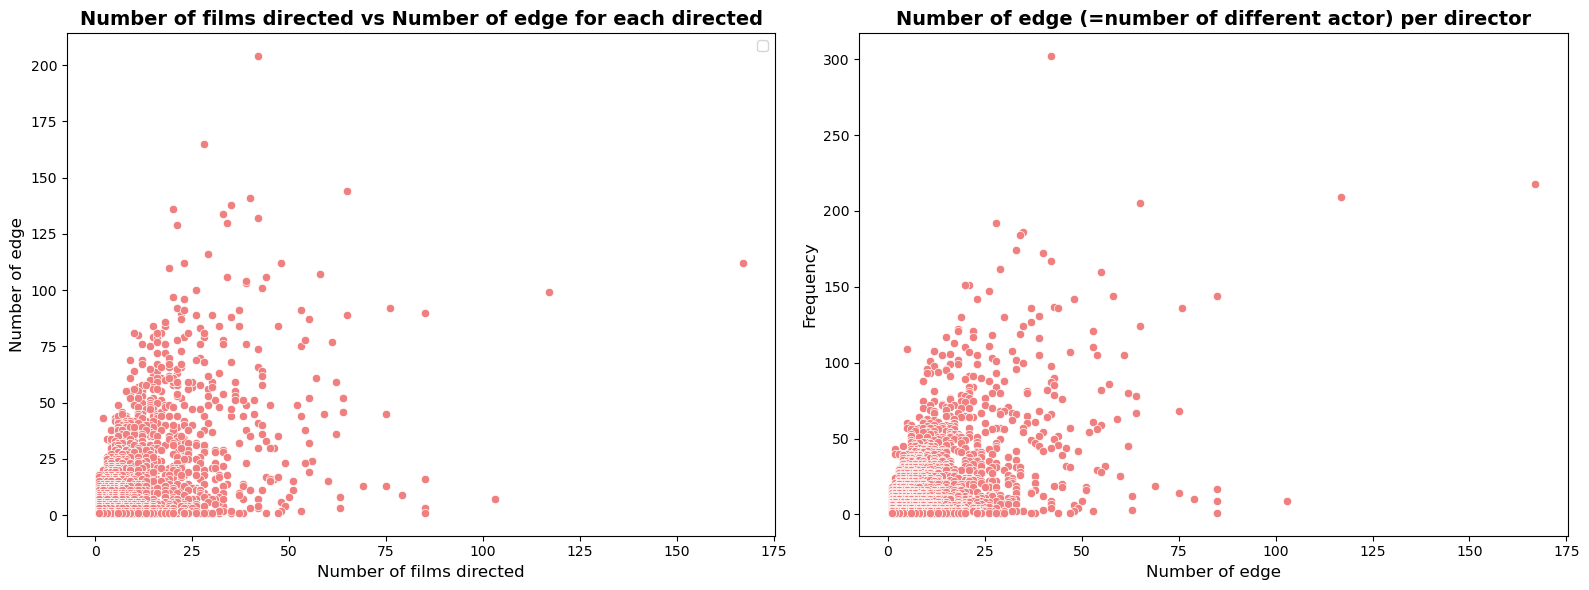

In [57]:
# Set the figure and subplots layout
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Total weight for each director
sns.scatterplot(x=Director_Success['Freebase_movie_ID'].apply(len), y=Director_Success['Number_of_actors'], color='lightcoral', ax=axes[0])
#axes[0].set_yscale('log')
axes[0].set_title('Number of films directed vs Number of edge for each directed',fontsize=14, fontweight="bold")
axes[0].set_xlabel('Number of films directed',fontsize=12)
axes[0].set_ylabel('Number of edge',fontsize=12)
axes[0].legend(fontsize=10)

# Total weight for each director vs Career start age
sns.scatterplot(x=Director_Success['Freebase_movie_ID'].apply(len),y=Director_Success['Sum_Weight'], color='lightcoral', ax=axes[1])
#axes[1].set_yscale('log')
axes[1].set_title('Number of edge (=number of different actor) per director',fontsize=14, fontweight="bold")
axes[1].set_xlabel('Number of edge',fontsize=12)
axes[1].set_ylabel('Frequency',fontsize=12)

# Plot
plt.tight_layout()
plt.show()

Les 2 graphes sont mega similaires 

In [58]:
Director_Success.columns

Index(['IMDb_director_ID', 'director_name', 'birthYear_director',
       'deathYear_director', 'Freebase_movie_ID', 'age_at_movie_release',
       'Career_Start_age', 'Number_of_films', 'Ratings', 'Mean_Rating',
       'Top_1_Genre', 'Top_1_Number', 'Top_1_Rating', 'Freebase_actor_ID',
       'Weight', 'Sum_Weight', 'Number_of_actors'],
      dtype='object')

list pour kmeans :
1) birthyear
2) career start age
3) Mean rating
4) number of films
5) number of edge
6) sum_weight
7) top genre => faire du one hot encoding avec ça N colonnes pour N genre et avoir un 1 dans la bonne colonne
8) age_at_movie_relase => analyser à part je pense

# Random

to-do random :
- finir texte 6 après avoir fini
- mettre tous les graphes comme voulait thibault
  

à faire analyse idée : 
- Comparer les directeurs et déterminer des "types" de directeur
    - à propos de ça j'ai demandé à pierre comment il a fait donc faudrait attendre sa réponse et voir ce qu'il en est
    - quentin tarantino très peu de film mais belle carrière 
- Comparer le poids des egdes moyen et le nombre de edge
- comparer somme total avec le poids moyen et le nombre de edge (mettre les 3 graphes côte à côte limite)
- définir les mecs qui sont les plus feed aussi et les analyser eux car au final c'est eux où y'a vraiment des trucs à dire (genre les directeurs à succès)
- regarder aussi par rapport à la période de vie (genre quel siècle et regarder si ça impacte les résultats => potentiellement juste parce que y'a moins d'acteur célèbres car c'était moins prolifique ou bien y'avait juste bcp plus d'acteurs car c'était le genre, ou juste ça tournait bcp, ou les emcs en faisaient 25 milles car ça débitait et la manière de faire les films étaient différents => maintenant en soit c'est long de faire un film, un directeur en lache un que toutes les x années)
- regarder la fréquence de faire les films par directeur
- regarder la top genre par directeur et le comparer avec celui des acteurs
- j'ai le age at movie release => faire un plot avec ça aussi